**Dependencies**  <a class="anchor" id="first_block"></a>

In [762]:
#import sys
#!{sys.executable} -m pip install GEOparse
#!{sys.executable} -m pip install GSEAPY

**Imports**

In [763]:
import GEOparse
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import re
from sklearn import manifold
import requests
import gseapy
import os
import math

#### Data loading

**Paper 1:**
doi:10.1016/j.cell.2016.02.065 [Genomic and Transcriptomic Features of Response to Anti-PD-1 Therapy in Metastatic Melanoma](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4808437/)

**Paper 2:**
doi:0.1016/j.celrep.2017.04.031 [Interferon Receptor Signaling Pathways Regulating PD-L1 and PD-L2 Expression](https://www.cell.com/cell-reports/fulltext/S2211-1247(17)30525-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2211124717305259%3Fshowall%3Dtrue)

Загружаем данные

In [764]:
%%capture --no-stdout

os.makedirs('data', exist_ok = True)
os.makedirs('interim', exist_ok = True)

geo_data_set1 = GEOparse.get_GEO(geo="GSE78220", destdir="./data/", include_data = True, silent = True)
geo_data_set2 = GEOparse.get_GEO(geo="GSE96619", destdir="./data/", include_data = True, silent = True)

urls = ['https://ftp.ncbi.nlm.nih.gov/geo/series/GSE78nnn/GSE78220/suppl/GSE78220_PatientFPKM.xlsx',
         'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE96nnn/GSE96619/suppl/GSE96619_PatientFPKM.xlsx',
          'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4808437/bin/NIHMS765463-supplement-6.xlsx']

for url in urls:
    fpkm_data = requests.get(url)
    with open('data/' + os.path.basename(url), 'wb') as output:
        output.write(fpkm_data.content)

gene_expression_set1 = pd.read_excel('data/GSE78220_PatientFPKM.xlsx', sheet_name='FPKM', index_col = 0)
gene_expression_set2 = pd.read_excel('data/GSE96619_PatientFPKM.xlsx', sheet_name='PD1cohort.OT.fpkm.Feb17.2016.tx', index_col = 0)


def clean_up_colnames(cols):
    return cols.str.replace('\..*?$|-.*?$', '', regex = True)

gene_expression_set1.columns = clean_up_colnames(gene_expression_set1.columns)

### Описание исходных данных  <a class="anchor" id="second_block"></a>

В GEO базе данных для наших статей присутствуют xlsx таблицы с FPKM и GSE series с описанием экспериментов и образцов. Кроме того, SRA содержит WES данные для первой статьи и RNA-seq данные для второй. Ключевые переменные для анализа в случае первого датасета - те, которые могут повлиять на выбор образцов для анализа, в том числе с точки зрения наличия выбросов и батч-эффекта. В случае второго датасета, необходимо проанализировать, насколько похожи между собой две выборки с точки зрения аннотации.

### Данные аннотации первого датасета  <a class="anchor" id="2a"></a>
Проанализируем GEO аннотацию первого (обучающего) датасета.

In [765]:
# there are also unnecessary columns with RNA-seq strandness data
unnecessary_columns = ['characteristics_ch1.14.stranded/unstranded rnaseq', 'characteristics_ch1.15.stranded/unstranded rnaseq',
                             'characteristics_ch1.13.stranded/unstranded rnaseq', 'geo_accession', 'source_name_ch1', 'description', 'relation']
# remove columns with starndness data and single values.
phenotype_set1 = geo_data_set1.phenotype_data.drop(unnecessary_columns, axis = 1)

# leave only columns with values that aren't single
columns_with_diverse_data = phenotype_set1.nunique() > 1

phenotype_set1 = phenotype_set1.loc[:, columns_with_diverse_data]

phenotype_set1.columns = phenotype_set1.columns.str.replace('characteristics_ch1\.\d+\.', '', regex = True)
cols_to_numeric = ['age (yrs)', 'overall survival (days)']

for col in cols_to_numeric:
    phenotype_set1.loc[:, col] = pd.to_numeric(phenotype_set1.loc[:, col], errors='coerce')

В датасете 28 образцов, отобранных у 27 пациентов:

In [766]:
pd.DataFrame(phenotype_set1.apply({'title':'nunique','patient id':'nunique'})).rename(columns = {0:'number of unique values'})

,number of unique values
title,28
patient id,27


Это связано с тем, что у пациента Pt27 было отобрано 2 оразца из двух меланом с разной anatomical location:

In [767]:
phenotype_set1.loc[phenotype_set1['title'].str.contains('Pt27'), ['patient id', 'title', 'anatomical location', 'overall survival (days)', 'vital status']].reset_index(drop = True)


,patient id,title,anatomical location,overall survival (days),vital status
0,Pt27,Pt27A,R upper arm,548.0,Alive
1,Pt27,Pt27B,R upper back,548.0,Alive


Впоследствии проверим, насколько они разнятся с точки зрения экспрессии, пока - учитываем дупликацию при построении гистограмм.

#### Время биопсии

Есть пациент, у которого биопсию брали уже в ходе лечения.

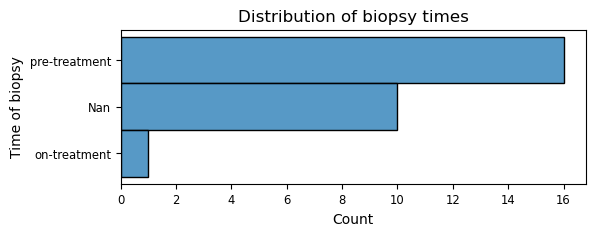

In [768]:
phenotype_set1['unique patients'] = phenotype_set1['title'] != 'Pt27B'

plt.figure(figsize=(6,2))
mpl.rcParams.update(mpl.rcParamsDefault)
#plt.style.use('seaborn-poster')
mpl.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "black",
                    'xtick.color' : "black",
                     'ytick.labelsize':'small',
                     'xtick.labelsize':'small',
                    'ytick.color' : "black",
                    'axes.labelsize':'medium',
                    'legend.fontsize': 'medium',
                      'figure.figsize': (6, 2),
                        'figure.titlesize':'small'})
sns.histplot(data=phenotype_set1[phenotype_set1['unique patients']].fillna({'biopsy time':'Nan'}), y = 'biopsy time')
plt.title('Distribution of biopsy times')
plt.ylabel('Time of biopsy')
plt.show()

Поскольку лечение может влиять на экспрессию генов, желательно включать в датасет на обучение только образцы которые отобрали pre-treatment, и on-treatment и NaN значения для данной переменной вызывают подозрения. Однако, в статье авторы пишут "*sampled prior to anti-PD-1 therapy (total 27 of 28 pretreatment tumors and 1 of 28 early on-treatment)*", то есть все образцы считаем отобранными pre-treatment.

#### Возраст

Пациент, у которого отобрали образец early on-treatment, ещё и очень молод для онкопациента, возраст 19 лет:

In [769]:
phenotype_set1.loc[phenotype_set1['biopsy time'] == 'on-treatment', ['biopsy time', 'patient id', 'age (yrs)', 'overall survival (days)', 'vital status', 'anatomical location']]

,biopsy time,patient id,age (yrs),overall survival (days),vital status,anatomical location
GSM2069836,on-treatment,Pt16,19,186.0,Dead,Lung


Проверим распределение возрастов пациентов:

NaN values in age column: 0


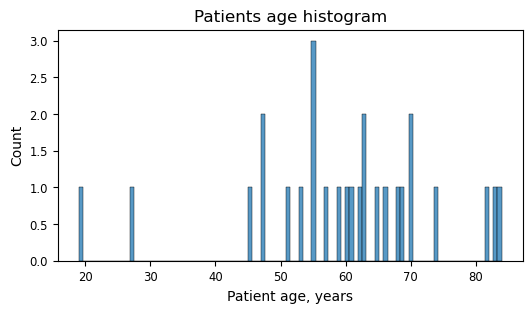

In [770]:
plt.figure(figsize=(6,3))
print('NaN values in age column: ' + str(phenotype_set1['age (yrs)'].apply(math.isnan).sum()))
sns.histplot(data=phenotype_set1[phenotype_set1['unique patients']], x = 'age (yrs)', bins = 100)
plt.title('Patients age histogram')
plt.xlabel('Patient age, years')
plt.show()

Крайние значения возрастов можно рассматривать как выбросы, проверим их c точки зрения статистики. Поскольку распределение возрастов пациентов с меланомой в разных источниках имеет колоколообразную форму (https://www.researchgate.net/figure/Distribution-of-cutaneous-melanoma-by-age_fig1_44627421, https://www.researchgate.net/figure/Age-group-distribution-among-the-melanoma-cases-at-Kamuzu-Central-Hospital-Malawi_fig1_332156805), будем считать его за нормальное (строго говоря, в датасете оно не нормальное, судя по критерию Андерсона-Дарлинга). Для нормально распределенной переменной можно применить median absolute deviation для оценки выбросов; данная метрика надёжнее обычного Z-score, поскольку выбросы слабо влияют на медиану.

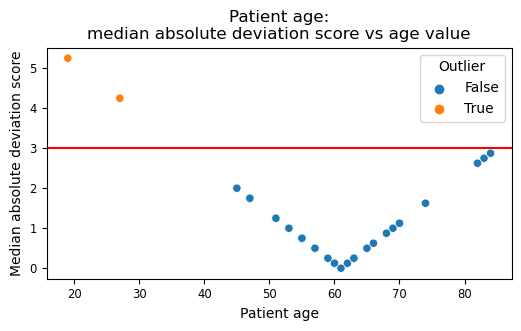

In [771]:
age_no_duplicated_patients = phenotype_set1[phenotype_set1['unique patients']]['age (yrs)']
median_deviations = abs(age_no_duplicated_patients - age_no_duplicated_patients.median())
mad_score = median_deviations/median_deviations.median()
plt.figure(figsize=(6,3))
sns.scatterplot(y = mad_score, x = age_no_duplicated_patients, \
                hue = mad_score > 3).set(title = 'Patient age:\nmedian absolute deviation score vs age value', \
                                                          ylabel = 'Median absolute deviation score', xlabel = 'Patient age')
plt.axhline(y = 3, color = 'r')
plt.legend(title='Outlier')
plt.show()

Таким образом, два пациента с возрастом менее 30 лет можно рассматривать как выбросы, поскольку стандартный порог для median absolute deviation score = 3. Пометим остальных пациентов как not_age_outlier.

In [772]:
phenotype_set1 = phenotype_set1.assign(not_age_outlier = phenotype_set1['age (yrs)'] > 30, inplase = True)


#### Ответ на терапию

В обучающем датасете нет пациентов, для которых не указан статус ответа на терапию. Пациенты с наличием ответа превалируют над 'Progressive disease'.

NaN values in "anti-pd-1 response" column: 0


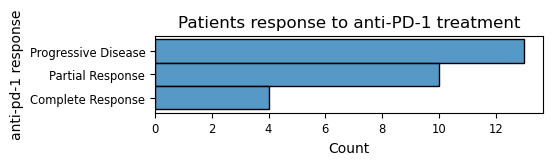

In [773]:
print('NaN values in "anti-pd-1 response" column: ' + str(phenotype_set1['anti-pd-1 response'].isna().sum()))
plt.figure(figsize=(5,1))
sns.histplot(data=phenotype_set1[phenotype_set1['unique patients']], y = 'anti-pd-1 response')
plt.title('Patients response to anti-PD-1 treatment')
plt.show()

Кодируем наличие ответа на терапию для использования в обучении, проверяем.

In [774]:
phenotype_set1['has_response'] = np.where(phenotype_set1['anti-pd-1 response'] == 'Progressive Disease', 0, 1)
phenotype_set1[['anti-pd-1 response', 'has_response']].reset_index(drop = True).drop_duplicates()

,anti-pd-1 response,has_response
0,Progressive Disease,0
1,Partial Response,1
6,Complete Response,1


**Пол**

NaN values in survival status column: 1


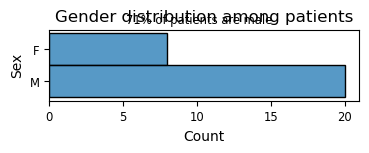

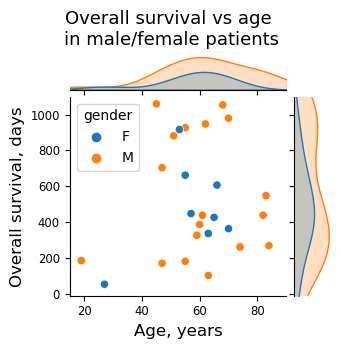

In [775]:
plt.figure(figsize=(4,1))
sns.histplot(data=phenotype_set1, y = 'gender').set(title = "Gender distribution among patients", ylabel = 'Sex')
plt.subplots_adjust(top=0.82)
plt.suptitle("{:.0f}".format(np.mean(phenotype_set1['gender'] == 'M')*100) + "% of patients are male")
mpl.rcParams['axes.titlepad'] = 22

print('NaN values in survival status column: ' + str(phenotype_set1['overall survival (days)'].apply(math.isnan).sum()))

h = sns.jointplot(data=phenotype_set1, x = 'age (yrs)', y = 'overall survival (days)', \
                hue = 'gender', kind = 'scatter', ylim = [-10,1100], xlim = [15,90], height = 3.5)
h.set_axis_labels('Age, years', 'Overall survival, days', fontsize=12)
plt.suptitle('Overall survival vs age \nin male/female patients', size = 13)
plt.subplots_adjust(top=0.85)
plt.show()

В датасете превалируют мужчины (71%). С точки зрения выживаемости и возраста, каких-то принципиальных отличий между мужчинами и женщинами в нашем датасете нет.

**Зависимость выживаемости от возраста**

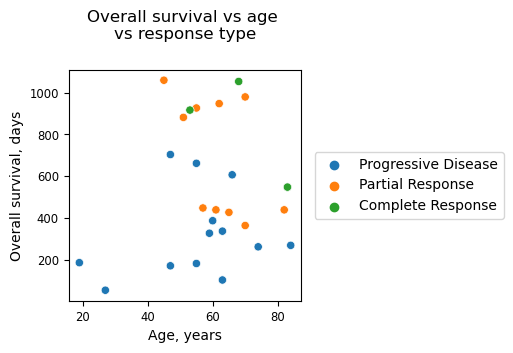

In [776]:
plt.figure(figsize=(3,3))
s_age_plot = sns.scatterplot(data=phenotype_set1, x = 'age (yrs)',\
                y = 'overall survival (days)', hue = 'anti-pd-1 response').set(title = 'Overall survival vs age \nvs response type', xlabel = 'Age, years', ylabel = 'Overall survival, days')
plt.legend(loc='center right', bbox_to_anchor=(1.9, 0.5), ncol=1)
plt.show()

Наиболее молодые пациенты в нашей выборке - среди наиболее короткоживущих. Ожидаемо, выживаемость дольше у пациентов с ответом на терапию. Среди пациентов старше 80 лет есть все три типа ответа на терапию, аргумент не рассматривать их как выбросы. Есть вылечившийся пациент мужского пола 69 лет, у которого не указана выживаемость:

In [777]:
print(phenotype_set1[phenotype_set1['overall survival (days)'].apply(math.isnan)][['patient id', 'gender', 'age (yrs)',  'overall survival (days)', 'anti-pd-1 response']].reset_index(drop = True))

  patient id gender  age (yrs)  overall survival (days) anti-pd-1 response
0        Pt8      M         69                      NaN  Complete Response


### Данные аннотации второго датасета <a class="anchor" id="2b"></a>
Удаляем монотонные переменные из аннотации второго набора данных, чистим colnames.

In [778]:
phenotype_set2 = geo_data_set2.phenotype_data.loc[:, geo_data_set2.phenotype_data.nunique() > 1]
phenotype_set2.columns = phenotype_set2.columns.str.replace('characteristics_ch1\.\d+\.', '', regex = True)

Во втором наборе данных 10 образцов представлены данными для 5 пациентов до и после лечения.

In [779]:
phenotype_set2[['subject status/id','treatment']].groupby(['subject status/id','treatment']).count()

Empty DataFrame
Columns: []
Index: [(melanoma patient 1, on-treatment), (melanoma patient 1, pre-treatment), (melanoma patient 2, on-treatment), (melanoma patient 2, pre-treatment), (melanoma patient 3, on-treatment), (melanoma patient 3, pre-treatment), (melanoma patient 4, on-treatment), (melanoma patient 4, pre-treatment), (melanoma patient 5, on-treatment), (melanoma patient 5, pre-treatment)]

Для предказания ответа оставим только данные образцов отобранных pre-treatment. В аннотации первого датасета помимо пола и возраста, присутствуют данные о предварительной терапии ингибиторами MAPK, наличии SNV/indel в BRAF и других онкогенах. Аннотация второго датасета очень скудная и с клинической точки зрения описывает лишь данные о статусе pre/on-treatment:

In [780]:
phenotype_set2_clean = phenotype_set2[phenotype_set2['treatment'] == 'pre-treatment']
phenotype_set2.apply(pd.unique, axis = 0)

title                [Pt1_baseline, Pt1_OnTx, Pt2_baseline, Pt2_OnT...
geo_accession        [GSM2536673, GSM2536674, GSM2536675, GSM253667...
source_name_ch1      [baseline_tumor biopsy, on-anti-PD-1 treatment...
subject status/id    [melanoma patient 1, melanoma patient 2, melan...
treatment                                [pre-treatment, on-treatment]
description          [Patient 1 melanoma, pre anti-PD-1 treatment, ...
relation             [BioSample: https://www.ncbi.nlm.nih.gov/biosa...
dtype: object

Поэтому ипользовать какие-бы то ни было данные из аннотации первого датасета как features для обучения модели невозможно.

### Анализ экспрессии генов <a class="anchor" id="third_block"></a>

Анализ экспрессии будем проводить с учётом дальнейшего использования данных для моделирования. Поскольку данные RNA-seq представлены уже в нормализованном виде (в виде FPKM), нормализация не требуется. Ключевые вопросы, на которые предстоит найти ответ:
* Есть ли в данных образцы, сильно отличающиеся от других с точки зрения паттерна экспрессии генов (выбросы).
* Есть ли выраженный batch-effect между образцами из разных больниц и из разных датасетов. Если второе будет иметь место - использование на втором датасете модели. обученной на первом, потребует проведения batch-коррекции.
Кроме того, проведём Gene Set Enrichment Analysis для последующего использования его результатов в моделировании.

Для задач визуализации - трансформируем значения экспрессии в log2(value + 1) для того чтобы уменьшить гетероскедастичность данных - уменьшить разницу в дисперсии у генов с низкой и высокой экспрессией.

In [781]:
gene_expression_set1_log2 = np.log2(gene_expression_set1 + 1)

Проверим распределение образцов первого датасета на MDS plot данных экспрессии генов.

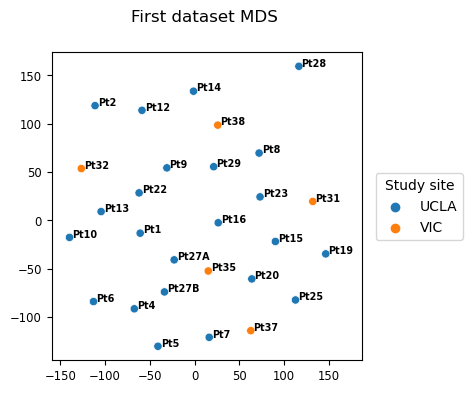

In [782]:
mds = manifold.MDS(random_state = 1)
X_transform = mds.fit_transform(gene_expression_set1_log2.T.values)

clean_sample_names = [re.sub('\\.baseline|\\.OnTx', '', s) for s in gene_expression_set1_log2.T.index]
plt.figure(figsize=(4,4))
mds1 = sns.scatterplot(x = X_transform[:,0], y = X_transform[:,1], hue = phenotype_set1['study site'])

for line in range(0,X_transform.shape[0]):
     mds1.text(x = X_transform[line,0] + 3,
     y = X_transform[line, 1],
             s = clean_sample_names[line], horizontalalignment='left',
     size='x-small', color='black', weight='semibold')
mds1.legend(loc='center right', bbox_to_anchor=(1.35, 0.5), ncol=1, title = 'Study site')
plt.xlim([min(X_transform[:,0])-20, max(X_transform[:,0]) + 40])
plt.title('First dataset MDS ')
plt.show()

Образцы в целом расположены равномерно, за исключением Pt28, который воспроизводимо при разных seed оказывается на некоторой дистанции от основной группы. Это один из наиболее пожилых пациентов:

In [783]:
phenotype_set1[phenotype_set1['title'] == 'Pt28']

,title,patient id,anti-pd-1 response,study site,gender,age (yrs),disease status,overall survival (days),vital status,previous mapki,anatomical location,nras,biopsy time,nf1,braf,nf1,unique patients,not_age_outlier,inplase,has_response
GSM2069844,Pt28,Pt28,Partial Response,UCLA,M,82,M1c,439.0,Dead,N,"Scalp, SC",NaN,pre-treatment,R1653C,NaN,NaN,True,True,True,1


Образцы из разных клиник (UCLA, VIC) не демонстрируют видимого batch-effect. Близкое расположение двух образцов из одного пациента (Pt27A и Pt27A) подтверждает корректность построения MDS. Теперь построим MDS с данными экспрессии из обоих датсетов.

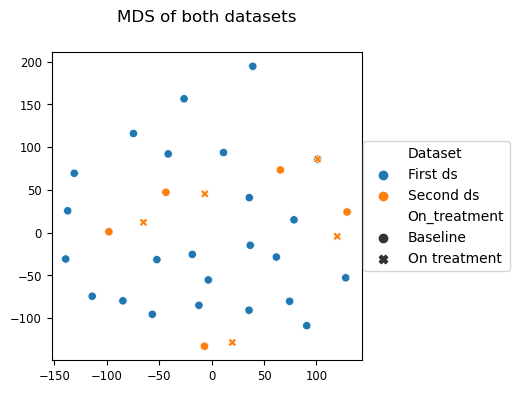

In [784]:
gene_expression_both_sets = gene_expression_set1.merge(gene_expression_set2, left_index=True, right_index=True)

gene_expression_both_sets_log2 = np.log2(gene_expression_both_sets + 1)

mds = manifold.MDS(random_state = 0)
plt.figure(figsize=(4,4))

X_transform = mds.fit_transform(gene_expression_both_sets_log2.T.values)

sample_ds_memberships = np.where(gene_expression_both_sets_log2.columns.isin(gene_expression_set1.columns), 'First ds', 'Second ds')

second_ds_samples_on_treatment = [s for s in gene_expression_set2.columns if re.search('On', s)]

on_treatment_sample = np.where(gene_expression_both_sets_log2.columns.isin(second_ds_samples_on_treatment), 'On treatment', 'Baseline')

mds_data_both_ds_with_annotation = pd.DataFrame(X_transform).assign(Dataset = sample_ds_memberships, On_treatment = on_treatment_sample)

p1 = sns.scatterplot(data = mds_data_both_ds_with_annotation, x = 0, y = 1, \
                     hue = 'Dataset', style = '\nOn_treatment')

p1.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)
plt.title('MDS of both datasets')
plt.xlabel('')
plt.ylabel('')
plt.show()

Образцы второго датасета не отделяются от образцов первого - хороший сигнал с точки зрения применимости модели, обученной на первом датасете, ко второму.

Удаляем все гены, которые не экспрессируются более чем в одном образце.

In [785]:
def filter_by_expression(exp_table, max_zero_samples = 0):
    sum_of_zero_values = exp_table.apply(lambda x: sum(x == 0), axis = 1)
    expressed = sum_of_zero_values <= max_zero_samples
    return exp_table.loc[expressed, :]

gene_expression_set1_expressed = filter_by_expression(gene_expression_set1)

gene_expression_set1_expressed_log2 = np.log2(gene_expression_set1_expressed + 1)

Одна из ключевых проблем обучения моделей на данных экспрессии генов - большое количество features (генов) на фоне небольшого количества образцов, что приводит к переобучению. Для её решения мы будем обучать модель не непосредственно на данных  экспрессии, а на результатах Gene Set Enrighment Analysis (GSEA). Это имеет смысл с точки биологической зрения, поскольку достоверное изменение экспрессии набора генов какой-либо функциональной группы, является более надёжным свидетельством их участия в каком-либо процессе, нежели изменение экспрессии отельных генов.

Подготовим наборы генов (functional gene expression signatures, Fges) для проведения GSEA, использованные в статье-источника обучющего датасета (S2 table, part B). Подавляющее большинство наборов доступно на сайте gsea-msigdb.org, загружаем их, конструируя URL. Кастомные списки из статьи (в основном, MAPK inhibitor-induced gene signatures) парсим из таблицы S2, раздела С. Все списки сохраняем в gmt файл "gene_sets.gmt". Исправляем ошибку в названии WILCOX_PRESPONSE_TO_ROGESTERONE_DN и приводим обновлённое название для ANASTASSIOU_CANCER_MESENCHYMAL_TRANSITION_SIGNATURE. Анализ проводим с помощью пакета GSEApy. Раздельно считаем ssGSEA для каждого образца и общий GSEA для получения корректных FDR для путей обогащенных в response/non-response образцах.  

In [786]:
%%capture --no-stdout
#get rid of read_excel import warnings 

gene_sets_table_mapk = pd.read_excel("data/NIHMS765463-supplement-6.xlsx", sheet_name='S2C', skiprows=2)
gene_sets_table_all = pd.read_excel("data/NIHMS765463-supplement-6.xlsx", sheet_name='S2B', skiprows=2)

gene_sets_all = []

supplementary_table_url =  urls[2]

# bring items to the following form: 
# set_name [url] gene1 gene2 (...)

for i, row in gene_sets_table_mapk.iterrows():
    gene_sets_all.append(row['Geneset'] + "\t" \
                         + supplementary_table_url + '\t' \
                         + re.sub(',', '\t', row['Gene Listing']))
    
# fix typo WILCOX_PRESPONSE_TO_ROGESTERONE_DN -> WILCOX_RESPONSE_TO_PROGESTERONE_DN
# provide updated name ANASTASSIOU_CANCER_MESENCHYMAL_TRANSITION_SIGNATURE -> ANASTASSIOU_MULTICANCER_INVASIVENESS_SIGNATURE
#https://www.gsea-msigdb.org/gsea/msigdb/cards/ANASTASSIOU_MULTICANCER_INVASIVENESS_SIGNATURE
gene_sets_table_all['Geneset_fixed'] = gene_sets_table_all['Geneset'].str.replace('WILCOX_PRESPONSE_TO_ROGESTERONE_DN', 'WILCOX_RESPONSE_TO_PROGESTERONE_DN').replace('ANASTASSIOU_CANCER_MESENCHYMAL_TRANSITION_SIGNATURE', 'ANASTASSIOU_MULTICANCER_INVASIVENESS_SIGNATURE')

is_non_mapk_set = np.logical_not([i in gene_sets_table_mapk[['Geneset']].values for i in gene_sets_table_all['Geneset_fixed']])
non_mapk_gene_sets = gene_sets_table_all['Geneset_fixed'][is_non_mapk_set]

for set in non_mapk_gene_sets:
    link = f"https://www.gsea-msigdb.org/gsea/msigdb/download_geneset.jsp?geneSetName={set}&fileType=gmt"
    response = requests.get(link)
    is_not_found_in_db = bool(re.search('not found', response.text))

    if is_not_found_in_db:
        raise NameError(set + ' set is not found, check spelling and search if renamed')
    else:
        gene_sets_all.append(response.text)
        
np.savetxt('interim/gene_sets.gmt', gene_sets_all, fmt='%s')

print('Saved', str(len(gene_sets_all)), 'gene sets out of 75')

Saved 75 gene sets out of 75


На первом этапе GSEA, найдём обогащение наборов генов между response vs non-response, используем модуль [GSEApy](https://gseapy.readthedocs.io/en/latest/introduction.html). Обогащение считаем для всех генов, экспрессирующихся минимум в одном образце, методом gseapy.gsea(). Критерий выбора оптимальных параметров - наибольшее сходство статистики обогащения для наборов генов между нашими вычислениями и опубликованными данными. Использована корреляция Спирмана для FDR наборов генов в наших расчётах и в данных датасета. Для получения FDR использовано 100 пермутаций.

In [787]:
# ssgsea code produces some undefined error from time to time - if this section fails, try to re-run a couple of times.

import gseapy as gp
import scipy

def ssgsea(exp_table, gmt_path):
    ssgsea_res = gp.ssgsea(data=exp_table, gene_sets=gmt_path, permutation_num=100, # reduce number to speed up test
                 outdir=None, no_plot=True, processes=4, seed= 7)
    return ssgsea_res

def filter_by_expression(exp_table):
    not_expressed_values = exp_table.apply(lambda x: sum(x == 0), axis = 1)
    expressed = not_expressed_values != exp_table.shape[1]
    return exp_table[expressed]

gene_expression_set1_expressed = filter_by_expression(gene_expression_set1)

gene_expression_set1_expressed_log = np.log2(gene_expression_set1_expressed + 1)

gene_expression_set1_expressed_log = gene_expression_set1_expressed_log[phenotype_set1['title']]

cls = list(np.where(phenotype_set1['anti-pd-1 response'] == 'Progressive Disease', 'NR', "R"))

gsea_res = gp.gsea(data=gene_expression_set1_expressed_log, 
                 gene_sets='interim/gene_sets.gmt', 
                 cls= cls, # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=100, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 no_plot=True, # Skip plotting
                 method='log2_ratio_of_classes',
                 processes=1, seed= 7,
                 format='png')

gsea_stats_table = gsea_res.res2d
gsea_stats_table.to_excel('interim/gsea_set1.xlsx')
gsea_stats_both = gsea_stats_table.merge(gene_sets_table_all.set_index('Geneset'), left_index = True, right_index = True, how = 'inner')
print('Correlation of calculated and published fdr values:')
print(scipy.stats.spearmanr(gsea_stats_both[['fdr', 'FDR']]))

Correlation of calculated and published fdr values:
SpearmanrResult(correlation=0.20927260774789777, pvalue=0.0820905887270708)


C точки зрения сходства ранжирования наборов генов по fdr, максимально приближенные к опубликованным данным результаты получаются при при использовании log2-трансформированных данных и режима log2_ratio_of_classes (по сравнению с использованием исходных FDR и режимами [ratio_of_classes и diff_of_classes](https://gseapy.readthedocs.io/en/latest/run.html); другие режимы GESEApy на наших данных не вычисляют обогащение). Однако,  достигнутый уровень корреляции при этом всего 0,2 (p-value = 0.08); причиной такой сравнительно низкой корреляции, возможно, является шумность FDR у наборов с низким обогащением. В данном наилучшем варианте gsea, 11 наборов генов являются достоверно обогащёнными между R vs NR с FDR <0.05. Полученные данные по FDR можно использовать для отбора наборов генов как features при обучении модели. Для обучения модели считаем ssgsea уже для отдельных образцов методом gseapy.ssgsea(), также с 100 пермутациями. Одновременно, считаем данные обогащения и для валидационного набора данных.

In [788]:
ssgsea_train_set = ssgsea(gene_expression_set1_expressed, 'interim/gene_sets.gmt')
ssgsea_train_set = ssgsea_train_set.res2d
ssgsea_train_set.to_excel('interim/ssgsea_set1.xlsx')

2022-06-27 09:27:35,699 run ssGSEA with permutation procedure, don't use these part of results for publication.


In [789]:
gene_expression_set2_baseline = gene_expression_set2[['Pt1-baseline', 'Pt2-baseline', 'Pt3-baseline', 'Pt4-baseline', 'Pt5-baseline']]
gene_expression_set2_baseline_expressed = filter_by_expression(gene_expression_set2_baseline)

gene_expression_set2_baseline_expressed.columns = gene_expression_set2_baseline_expressed.columns.str.replace('-.*?$', '_set2', regex = True)

ssgsea_set2 = ssgsea(gene_expression_set2_baseline_expressed, 'interim/gene_sets.gmt').res2d
ssgsea_set2.to_excel('interim/ssgsea_set2.xlsx')

2022-06-27 09:29:38,518 Warning: dropping duplicated gene names, only keep the first values
2022-06-27 09:29:40,339 run ssGSEA with permutation procedure, don't use these part of results for publication.


Ошибка "*run ssGSEA with permutation procedure, don't use these part of results for publication*" - баг, потому что при вычислениях ssgsea использовано значение permutation_num=100.
Визуализируем полученные данные GSEA:

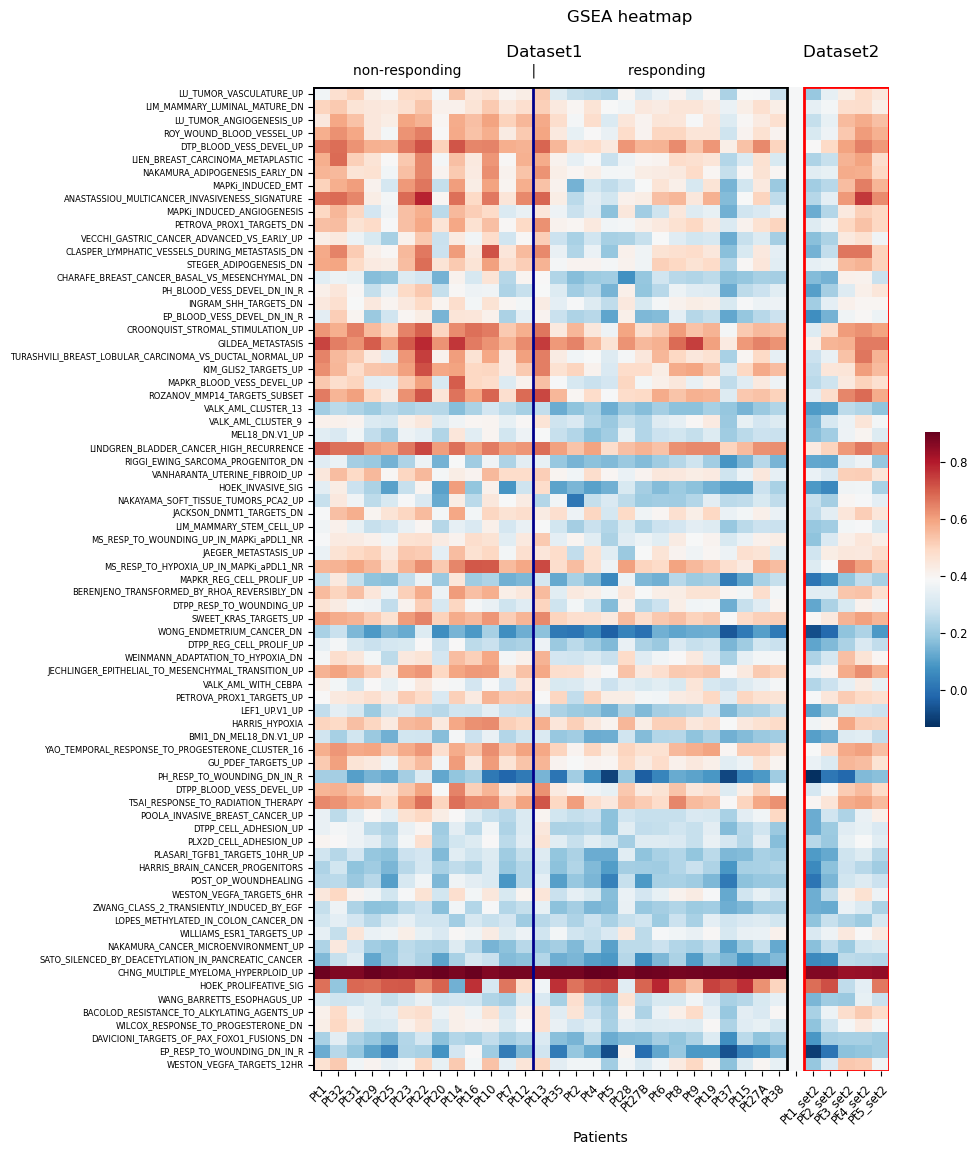

In [790]:
from matplotlib import patches

phenotype_set1_ordered_response = phenotype_set1.sort_values('has_response')
sample_order = phenotype_set1_ordered_response['title']

#gsea_stats_table = pd.read_excel('interim/gsea_set1.xlsx', index_col=0)
gsea_stats_table = gsea_stats_table.sort_values('fdr')

#ssgsea_train_set = pd.read_excel('interim/ssgsea_set1.xlsx', index_col=0)
ssgsea_train_set_ordered = ssgsea_train_set.loc[gsea_stats_table.index,sample_order]
#ssgsea_train_set_ordered.index = ssgsea_train_set_ordered.index.str.capitalize()

dummy_table = pd.DataFrame({' ':0.38}, index = ssgsea_train_set_ordered.index)

ssgsea_both = pd.merge(ssgsea_train_set_ordered, dummy_table, left_index = True, right_index = True)
ssgsea_both = pd.merge(ssgsea_both, ssgsea_set2, left_index = True, right_index = True)

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(ssgsea_both, cbar_kws={"shrink": .3}, cmap="RdBu_r")

rect_width = sum(phenotype_set1_ordered_response['has_response'] == 0)
ax.add_patch(patches.Rectangle((0, 0), rect_width, ssgsea_train_set_ordered.shape[0], edgecolor='darkblue', fill=False, lw=2))
ax.add_patch(patches.Rectangle((29, 0), 5, ssgsea_train_set_ordered.shape[0], edgecolor='red', fill=False, lw=2))
ax.add_patch(patches.Rectangle((0, 0), 28, ssgsea_train_set_ordered.shape[0], edgecolor='black', fill=False, lw=2))

plt.title('GSEA heatmap           \n \n \
            Dataset1                                          Dataset2', size = 12, x = 0.60)
plt.subplots_adjust(left=0.3, top=0.93)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

plt.yticks(size=6)
mpl.rcParams['axes.titlepad'] = 25
plt.suptitle('non-responding                |                     responding', 
             y=0.95, size = 10, x = 0.48)
plt.xlabel('Patients')
plt.show()

В heatmap наборы генов отсортированы по возрастанию FDR, то есть значимость обогащения убывает сверху вниз. В top-10 у нас 3 сигнатуры, которые были в топе в GSEA в training dataset (ROY_WOUND_BLOOD_VESSEL_UP, MAPKi_INDUCED_EMT, MAPKi_INDUCED_ANGIOGENESIS):

In [791]:
print('Top-10 enriched gene sets from training dataset')
print(gene_sets_table_all.sort_values('FDR').iloc[0:10,0:3])

Top-10 enriched gene sets from training dataset
                                         Geneset      Pval       FDR
0                      ROY_WOUND_BLOOD_VESSEL_UP  0.000598  0.048404
1                              MAPKi_INDUCED_EMT  0.001076  0.086058
2                          INGRAM_SHH_TARGETS_DN  0.001121  0.088587
3                      WESTON_VEGFA_TARGETS_12HR  0.001419  0.110648
4                                  LEF1_UP.V1_UP  0.001475  0.113550
5                     MAPKi_INDUCED_ANGIOGENESIS  0.002111  0.160414
6                      WONG_ENDMETRIUM_CANCER_DN  0.003179  0.238456
7  CHARAFE_BREAST_CANCER_BASAL_VS_MESENCHYMAL_DN  0.003232  0.239181
8                           POST_OP_WOUNDHEALING  0.003678  0.268491
9                       MAPKR_REG_CELL_PROLIF_UP  0.003748  0.269878


Пациент Pt13 визуально судя по heatmap скорее относится к группе пациентов, не реагирующих на терапию, но он реагировал и излечился. Среди образцов второго датасета есть видимое различие между образцами пациентов, реагировавших на терапию (Pt1, Pt2) и тех, которые не реагировали (Pt3-5). При этом, паттерн обогащения сходен с аналогичными  

### Моделирование <a class="anchor" id="fourth_block"></a>

Апробируем knn и random forest алгоритмы. Будем оптимизировать параметры алгоритмов и искать оптимальный набор данных для обучения с помощью кросс-валидации. Для этого, используем GridSearchCV в различных вариантах анализа: 
* c сохранением и удалением пациентов которые являются выбросами с точки зрения возраста, и   
* с использованием всех результатов ssGSEA и только достоверно обогащённых между Response/No response с FDR < 0.05.

В качестве критерия оптимизации для GridSearchCV будем использовать увеличение доли пациентов, действительно реагирующих на терапию (true positives) как среди всех детектированных positives (true positives/detected positives), так и среди всех реагирующих на терапию (true positives/(true positives + false negatives). Для этого, в GridSearchCV задаём как метрику оптимизации scoring = F1, геометрическое среднее recall и precision.
Результаты ssgsea перед обучением нормализовываем с помощью StandardScaler().fit_transform.

In [792]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def grid_search_tuned(model, param_grid):
    return GridSearchCV(model, param_grid, cv=10, verbose=False, scoring='f1')

def GridSearchCV_knn(X, y):
    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': np.arange(1, 19), \
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], \
                 'metric': ['euclidean', 'manhattan', 'minkowski']}
    knn_gscv = grid_search_tuned(knn, param_grid)
    return knn_gscv.fit(X, y)
    
def GridSearchCV_RF(X, y):
    rf = RandomForestClassifier()
    param_grid = {'criterion':('gini', 'entropy'), 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10]}
    rf_gscv = grid_search_tuned(rf, param_grid)
    return rf_gscv.fit(X, y)


# wrapper around GridSearchCV for knn and random forest to return their results as a dataframe for comparison
def iterate_over_models(X, y, outliers_status, significance_level):
    
    modelling_stats_inner = []
    for model in ['RF', 'KNN']:
        if model == 'KNN':
            current_results = GridSearchCV_knn(X, y)
        else:
            current_results = GridSearchCV_RF(X, y)
            
        modelling_stats_inner.append({'model':model, 'outliers_status': outliers_status, \
                                      'max gene set fdr':significance_level, \
                                       'score':current_results.best_score_, \
                                        'N of patients':X.shape[0], 'N of gene sets':X.shape[1], \
                                        'best_params':current_results.best_params_})
    return pd.DataFrame(modelling_stats_inner)

modelling_stats = pd.DataFrame()

for outliers_status in ['remove','keep']:
    if outliers_status == 'remove':
        phenotype_set1_filtered = phenotype_set1[phenotype_set1['not_age_outlier']]
    else:
        phenotype_set1_filtered = phenotype_set1
    
    for significance_level in [1,0.05]:
        
        current_list_of_sets = gsea_stats_table[gsea_stats_table['fdr'] < significance_level].index
        ssgsea_train_set_filtered = ssgsea_train_set.loc[current_list_of_sets,phenotype_set1_filtered['title']]
        
        X = preprocessing.StandardScaler().fit_transform(ssgsea_train_set_filtered.T)
        y = phenotype_set1_filtered['has_response']
        
        modelling_stats_current = iterate_over_models(X, y, outliers_status, significance_level)
        
        modelling_stats = pd.concat([modelling_stats, modelling_stats_current])

In [793]:
print('Results of modelling cross-validation using different data:\n')

print(modelling_stats.sort_values('score', ascending = False).iloc[:,0:6])

Results of modelling cross-validation using different data:

  model outliers_status  max gene set fdr     score  N of patients  \
1   KNN            keep              1.00  0.873333             28   
1   KNN          remove              1.00  0.850000             26   
1   KNN          remove              0.05  0.850000             26   
0    RF            keep              0.05  0.843333             28   
1   KNN            keep              0.05  0.843333             28   
0    RF          remove              0.05  0.833333             26   
0    RF          remove              1.00  0.816667             26   
0    RF            keep              1.00  0.810000             28   

   N of gene sets  
1              68  
1              68  
1              11  
0              11  
1              11  
0              11  
0              68  
0              68  


Полученная таблица отображает режимы, в которых обучалась модель: были ли удалены слишком молодые пациенты (outliers status), и использовались ли в обучении данные ssGSEA для всех наборов генов или только наборов с достоверной разницей между Response/No response пациентами по данным GSEA.

Наибольший F1 score (0,87) достигается в следующих режимах:
* Random Forest на полной выборке пациентов (n = 28) при обучении на данных GSEA только для 11 наборов генов с fdr < 0.05.
* KNN на полной выборке пациентов при обучении на полных данных GSEA, включающих все наборы генов.

При повторных запусках кода в части итераций максимальный score у Random Forest и/или KNN score оказывается 0,85 вместо 0.87, но каких-то принципиальных изменений в сравнительном качестве моделей при этом не наблюдается.
Предпочтительнее первый вариант обучения, поскольку он минимизирует количество переменных и снижает риск переобучения модели.
При обучении будем использовать найденные GridSearchCV оптимальные параметры для random forest, они сохранены в таблице modelling_stats:

In [794]:
best_model_stats = modelling_stats.sort_values('score', ascending = False).iloc[1]
print(best_model_stats)

model                                                             KNN
outliers_status                                                remove
max gene set fdr                                                  1.0
score                                                            0.85
N of patients                                                      26
N of gene sets                                                     68
best_params         {'algorithm': 'auto', 'metric': 'euclidean', '...
Name: 1, dtype: object


In [795]:
#обучаем заново с оптимальными параметрами.
rnd = RandomForestClassifier(criterion= 'entropy', min_samples_leaf = 6)
significant_sets = gsea_stats_table[gsea_stats_table['fdr'] < 0.05]
ssgsea_train_filtered = ssgsea_train_set.T.loc[:,significant_sets.index]

X = preprocessing.StandardScaler().fit_transform(ssgsea_train_filtered)

rnd.fit(X, phenotype_set1_filtered['has_response'].values)

ssgsea_set2_signif_t = ssgsea_set2.loc[significant_sets.index,:].T
ssgsea_test_scaled = preprocessing.StandardScaler().fit_transform(ssgsea_set2_signif_t)

response_predicted = rnd.predict(ssgsea_test_scaled)

print(pd.DataFrame({'Patient':clean_up_colnames(ssgsea_set2_signif_t.index), 'predicted response':response_predicted,
                   "response actual":[1,1,0,0,0]}))

    Patient  predicted response  response actual
0  Pt1_set2                   1                1
1  Pt2_set2                   1                1
2  Pt3_set2                   0                0
3  Pt4_set2                   0                0
4  Pt5_set2                   0                0


В соответствии с полученными результатами, ответ на anti-PD-1 терапию ожидается у Pt1 и Pt2 из второго набора данных, что совпадает с фактическими данными из статьи ([Figure 6E](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6420824/)). Таким образом, модель успешно предсказала ответ на anti-PD-1 терапию.